In [1]:
%load_ext autoreload
%autoreload 2

import qc_utils as utils
import cirq
from cirq.contrib.svg import SVGCircuit
import matplotlib.pyplot as plt
import sympy
import itertools
import numpy as np
import json 

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

# Forward

This work follows the arxiV paper:

["Portfolio rebalancing experiments using the Quantum Alternating Operator Ansatz", M. Hodson, B. Ruck, H. Ong, D. Garvin, S. Dulman, arXiV:1911.05296](https://arxiv.org/abs/1911.05296)

# Table of contents

### 1. [The portfolio rebalancing optimization problem]()
####  1.1 [Parameter definitions](#parameter_definitions)
### 2. [Construction of QAOA circuit](#construction_of_QAOA_circuit)
#### 2.1 [Brute force search](#brute_force_search)
#### 2.2 [QAOA grid search](#QAOA_grid_search)
#### 2.3 [QAOA results summary](#QAOA_results_summary)

### 3. [Construction of AOA circuit](#construction_of_AOA_circuit)
#### 3.1 [AOA grid search](#AOA_grid_search)
#### 3.2 [AOA results summary](#AOA_summary)

# The portfolio rebalancing optimization problem

Suppose there are $N$ risky assets that have a mean return $\mu_k$ and a volatility $\sigma_k$. There is a vector ${\bf z} = [z_1, ..., z_n]$, where $z_k = \lbrace -1,0,1 \rbrace $ that represents our current holdings. A value of $+1 (-1)$ indicates that we currently hold (short) the $k$-th asset and a value of $0$ indicates that we do not take any position for that asset.

The optimal portfolio is the one that minimizes the return-risk cost function $C_{RR}({\bf z})$ given by

$$
C_{RR}({\bf z}) = -\sum_k (1-\lambda) r_k z_k + \lambda\sum_{kj} \sigma_{kj} z_k z_j,
$$


where $0 \leq \lambda \leq 1$ represents an asset manager control parameter that balances the return-risk trade-off, $\lambda=0$ favours returns and $\lambda = 1$ favours the risk.

## The trading costs

The change of the vector ${\bf z}$ incuurs trading fees. Those amount of fees that this change genertes will be given contained in the trading-cost function

$$
C_{TC}({\bf z}) = \sum_j (1-\delta(z_i-y_i))T,
$$


where the vector ${\bf y}$ represents the previous positions of the portfolio, $T$ is the transaction fee and $\delta$ is the discrete Kronecker delta function.

## Trading constraints

The above problem should be solved under the condition that we have a discrete number of assets to be invested

$$
\sum_j z_j =D 
$$

# Function encoding

The variable $z_j = \lbrace -1,0,1\rbrace$ is encoded as a difference of two spin variables 
as

$$
z_j = \frac{1}{2}\left( s^+_j-s^-_j \right),
$$
where 

$$
s^{\pm}_j = \lbrace -1,1 \rbrace.
$$


### Return-risk function

$$
\begin{align}
C_{RR}({\bf z}) &= -\sum_k (1-\lambda) r_k z_k + \lambda\sum_{kj} \sigma_{kj} z_k z_j, \\
 &= -\sum_k \frac{ (1-\lambda)}{2} r_k\left( s^+_k-s^-_k\right) + \frac{\lambda}{4}\sum_{kj} \sigma_{kj} \left( s^+_k-s^-_k\right) \left( s^+_j-s^-_j\right),
\end{align}
$$

### Soft constraint encoding

$$
\begin{align}
P_{\rm INV}(z) &= A\left(\sum_j z_j-D\right)^2\\
&= A\left(\sum_{jk} z_k z_j-2D\sum_j z_j+D^2 \right)\\
&= \sum_{kj} \frac{A}{4} \left( s^+_k s^+_j-s^+_k s^-_j - s^-_k s^+_j+ s^-_k s^-_j \right) -AD\sum_{j} (s^+_j-s^-_j)+AD^2
\end{align}
$$


The simple method of choosing the the penalty scaling coefficient $A$ is to choose 

$$
A > \text{max}\lbrace C_{RR}({\bf s})+C_{TC}({\bf s}) \rbrace-\text{min}\lbrace C_{RR}({\bf s})+C_{TC}({\bf s}) \rbrace
$$

### Transaction cost encoding

To encode the transcation cost, we factorize the discrete Dirac-delta function as

$$
\delta(z-y) = c_0(z-y-2)(z-y-1)(z-y+1)(z-y+2),
$$

where $z,y \in \lbrace -1,0,1 \rbrace$ noting that $\delta(z-y) =0$ except when $z=y$, where $\delta(z-y) =1$. This implies that

$$
\begin{align}
\delta(z-y) &= \frac{1}{4}(z-y-2)(z-y-1)(z-y+1)(z-y+2),\\
&= \left(\frac{3}{2}y^2-1 \right)z^2+(1-y^2)+\frac{1}{2}yz.
\end{align}
$$

and so,

$$
\begin{align}
C_{TS}(s_i) &= T(1 - \delta(s_i-y_i) ),\\
&= T \left(1-\left(\frac{3}{2}y^2-1 \right)z^2-(1-y^2)-\frac{1}{2}yz \right),\\
&= T \left(-\frac{1}{2}\left(\frac{3}{2}y^2-1 \right)(1-s^+_is^-_i)-y^2-\frac{1}{4}y(s^+_i- s^-_i). \right)
\end{align}
$$

This last function generates all of the correct combinations except for $(y_i,s_i^+,s_i^-)=(0,1,1)$. There we would like this function to generate the value $T$ instead of $0$. To carry this out, we will add a function $g(s_i)$ that is zero for $y^2_i=1$ and for  $y_i,s_i^+,s_i^- = (0,-1,-1),(0,-1,1),(0,-1,1)$. Furthermore,$g(s^+_i,s^-_i)=T$. This function is easily found to be

$$
g(s_i) = \frac{T}{4}\left(1+s^+_i s^-_i +s^-_i +s^+_i \right)(1-y^2_i).
$$


Adding this additional peanlization term, we arrive at the cost-function encoding 

$$
\begin{align}
C_{TS}(s_i) = \frac{1}{4}T\left( 3+(1-y^2_i-y_i)s^{+}_{i}+(1-y^2_i+y_i)s^{-}_{i}+(2y^2_i-1)s^{+}_{i}s^{-}_{i} \right)
\end{align}
$$


In [2]:
# Here we verify that this cost function reproduces all values in the paper 
# by M. Hodson 2019


def C_stored(sm,sp,y):
    '''
    The Tabulated values, (T=1)
    for Table II of Hodson et. al. 2019
    '''
    
    sm = int((sm+1)/2)
    sp = int((sp+1)/2)
    y = y+1
    
    A = np.zeros((3,2,2))
    A[0,0,0]=1
    A[0,0,1]=1
    A[0,1,0]=0
    A[0,1,1]=1
    
    A[1,0,0]=0
    A[1,0,1]=1
    A[1,1,0]=1
    A[1,1,1]=1
    
    A[2,0,0]=1
    A[2,0,1]=0
    A[2,1,0]=1
    A[2,1,1]=1
    
    return A[y,sm,sp]

def C_TC(sm,sp,y):
    '''
    C_{TC}(s,y) function
    
    sm -> s^-_k
    sp -> s^+_k
    
    where:
    sm: {-1,1}
    sp: {-1,1}
    '''
    return 1/4*(3+(1-y**2-y)*sp+(1-y**2+y)*sm+(2*y**2-1)*sp*sm)

# Enumerate all possible input combinations
y_index = [-1,0,1]
sp_index = [-1,1]
sm_index = [-1,1]
combinations = itertools.product(y_index,sp_index,sm_index)

for y,sp,sm in list(combinations):
    print('Function input values: y={}, s^+_k={}, s^-_k={}'.format(y,sp,sm))
    print('Cost function value: {}'.format(C_TC(sm,sp,y))) 
    print('Stored value: {}'.format(C_stored(sm,sp,y)))
    print('')

Function input values: y=-1, s^+_k=-1, s^-_k=-1
Cost function value: 1.0
Stored value: 1.0

Function input values: y=-1, s^+_k=-1, s^-_k=1
Cost function value: 0.0
Stored value: 0.0

Function input values: y=-1, s^+_k=1, s^-_k=-1
Cost function value: 1.0
Stored value: 1.0

Function input values: y=-1, s^+_k=1, s^-_k=1
Cost function value: 1.0
Stored value: 1.0

Function input values: y=0, s^+_k=-1, s^-_k=-1
Cost function value: 0.0
Stored value: 0.0

Function input values: y=0, s^+_k=-1, s^-_k=1
Cost function value: 1.0
Stored value: 1.0

Function input values: y=0, s^+_k=1, s^-_k=-1
Cost function value: 1.0
Stored value: 1.0

Function input values: y=0, s^+_k=1, s^-_k=1
Cost function value: 1.0
Stored value: 1.0

Function input values: y=1, s^+_k=-1, s^-_k=-1
Cost function value: 1.0
Stored value: 1.0

Function input values: y=1, s^+_k=-1, s^-_k=1
Cost function value: 1.0
Stored value: 1.0

Function input values: y=1, s^+_k=1, s^-_k=-1
Cost function value: 0.0
Stored value: 0.0

Funct

# QAOA algorithm

The QAOA A

$$
|\psi_0\rangle = |+ \rangle^{\otimes N}
$$


$$
\begin{align}
|\psi \rangle = \prod_{k=1}^{p} U(B,\beta_k)U(C,\gamma_k)|\psi_0\rangle
\end{align}
$$



$$
\begin{align}
 U(B,\beta_k) &= \text{Exp}\left( -i \beta_k B \right) \\
 U(C,\gamma_k) &= \text{Exp}\left( -i \gamma_k C \right) 
\end{align}
$$

# AOA algorithm

$$
| \psi_0 \rangle = |10\rangle^{\otimes D} \otimes \left( \frac{1}{\sqrt{2}}|00\rangle+\frac{1}{\sqrt{2}}|11\rangle \right)^{\otimes \left(N-D\right)}
$$

$$
\begin{align}
|\psi \rangle = \prod_{k=1}^{p} U(B,\beta_k)U(C,\gamma_k)| \psi_0 \rangle
\end{align}
$$



$$
\begin{align}
 U(\beta_k) &= \text{Exp}\left( -i \beta_k H \right) \\
 U(\gamma_k) &= \text{Exp}\left( -i \gamma_k H \right) 
\end{align}
$$

In [3]:
%load_ext autoreload
%autoreload 2

import qc_utils as utils
import cirq
from cirq.contrib.svg import SVGCircuit
import matplotlib.pyplot as plt
import sympy
import itertools
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id='parameter_definitions'></a>

# Definition of parameters for the notebook

In [4]:
# Do you want to load the data from a file?
load_from_file = False
data_folder = 'results_N5'

# Define the number of portfolios to optimize
N_portfolio = 5

# For the grid search 
N_grid=20
N_trials_grid = 100

N_trials_scipy = 50

# Gradient descent 
N_trials_gd = 50
N_gd_steps = 30
lr = 0.1

# Parameters of the cross-entropy optimizer for the beta, gamma angles 
N_trials_ce = 100
N_ce_iterations = 10
N_ce_samples = 50
f_elite = 0.1

<a id='brute_force_search'></a>

# Brute force search calculation 

Here we compute the optimal solution using a brute-force search.

In [5]:
# Instantiate the portfolio 
portfolio1 = utils.Portfolio(N_portfolio=N_portfolio)

# Get the benchmark parameters
benchmark_parameters = portfolio1.benchmark_values()

# Determine the results via a bruteforce search
best_bruteforce_result = portfolio1.brute_force_search(benchmark_parameters)


print('='*100)
print('Brute-Force state: ', best_bruteforce_result['minimum_cost_states'])
print('Brute-Force energy: ', best_bruteforce_result['minimum_cost'])
print('='*100)

Brute-Force state:  [[1 0 1 0 1]]
Brute-Force energy:  0.00038080000000000004


<a id='construction_of_QAOA_circuit'></a>

# Construct the QAOA circuit 

In this section we use implement the QAOA circuit.

In [6]:
# Generate a QAOA circuit with p=1 depth
QAOA_circuit = portfolio1.QAOA_circuit(p=1)

# plot the circuit
SVGCircuit(QAOA_circuit)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


<a id='QAOA_grid_search'></a>
## Grid search of the angles for $p=1$

For visualization purposes we now conduct a grid-search of the QAOA angle parameters and plot the expected value of the cost function.

In [7]:

# Determine the p=1 energy landscape for the QAOA 
if(load_from_file is True):
    QAOA_results = portfolio1.load_data_from_json(data_folder+'/QAOA_results.json')
else:
    QAOA_results = portfolio1.grid_search(QAOA_circuit,N_grid=N_grid,parameters=benchmark_parameters,n_trials=N_trials_grid)
    portfolio1.save_data_as_json(QAOA_results,data_folder+'/QAOA_results.json')

    
penalty_cost_grid_QAOA = QAOA_results['penalty_cost_grid']
total_cost_grid_QAOA = QAOA_results['total_cost_grid']
best_holdings_QAOA = QAOA_results['min_portfolio_holdings']

gamma_grid = QAOA_results['gamma_grid']
beta_grid = QAOA_results['beta_grid']


Minimum cost solution:  0.021308115599999997
beta: 0.63* pi
gamma: 1.79* pi 


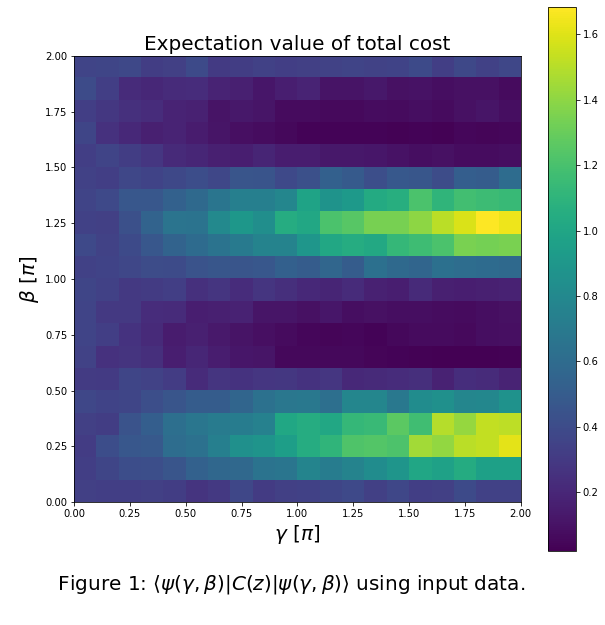

In [8]:
extent = [0.0,2.0, 0.0, 2.0]

#best_index= np.argwhere(total_cost_grid==QAOA_results['minimum_cost']).flatten()


print('='*100)
print('Minimum cost solution: ', QAOA_results['minimum_cost'])
print('beta: {:.2f}* pi'.format(QAOA_results['min_betas']/np.pi))
print('gamma: {:.2f}* pi '.format(QAOA_results['min_gamma']/np.pi))
print('='*100)

plt.figure(figsize=(10,10))
plt.title('Expectation value of total cost',size=20)
plt.imshow(total_cost_grid_QAOA[::-1],extent=extent)
plt.colorbar()
plt.xlabel(r'$\gamma \ [\pi]$',size=20)
plt.ylabel(r'$\beta \ [\pi]$',size=20)

text = r'''
        Figure {}: $\langle \psi(\gamma,\beta)|C(z)|\psi(\gamma,\beta) \rangle$ using input data.
        '''.format(1)
plt.text(-.3,-0.5, text, ha='left', size=20)

plt.show()

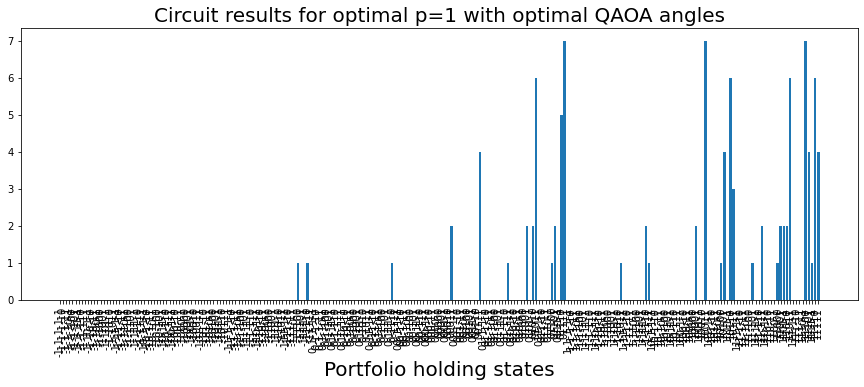

In [9]:
# Show the samples obtained from the experiments with the optimal angles

plt.figure(figsize=(15,5))
plt.title("Circuit results for optimal p=1 with optimal QAOA angles",size=20)
plt.bar(np.arange(len(QAOA_results['min_portfolio_holdings']['labels'])), QAOA_results['min_portfolio_holdings']['counts'], tick_label=QAOA_results['min_portfolio_holdings']['labels'])
plt.xticks(rotation=90)
plt.xlabel('Portfolio holding states',size=20)
plt.show()

In [10]:
# Get the best results from the gridsearch

best_QAOA_result = portfolio1.determine_best_solution_from_trials(benchmark_parameters,best_holdings_QAOA)

print('='*100)
print('QAOA results:')
print('Cost of optimal states: E={:.6f}'.format(best_QAOA_result['minimum_cost']))
print('Minimum energy states: z={}'.format(best_QAOA_result['minimum_cost_states']))
print('Probability of minimum cost states: p={}'.format(best_QAOA_result['minimum_cost_probabilities']))
print('='*100)

QAOA results:
Cost of optimal states: E=0.000381
Minimum energy states: z=[[1 0 1 0 1]]
Probability of minimum cost states: p=[0.04]


In [11]:
p_depth = np.array([1,2,3,4]).astype(int)

QAOA_circuit_p_array = []


# Generate a QAOA circuit with p=1 depth
for p in p_depth:
    QAOA_circuit_p_array.append(portfolio1.QAOA_circuit(p=p))

## Optimize the QAOA cicuit using Scipy optimizer

In [12]:
# Optimize the circuit using Scipy-optimizer
scipy_optimization_array_QAOA= []


if(load_from_file is True):
    
    for p in range(len(p_depth)):
        scipy_optimization_results = portfolio1.load_data_from_json(data_folder+'/QAOA_scipy_p'+str(p)+'.json')
        scipy_optimization_array_QAOA.append(scipy_optimization_results)
else:
    for k in range(len(p_depth)):
        QAOA_circuit_p = QAOA_circuit_p_array[k]
        scipy_optimization_results = portfolio1.optimize_circuit(circuit=QAOA_circuit_p,
                                                             parameters=benchmark_parameters,
                                                             n_trials=N_trials_scipy,
                                                             p=p_depth[k])
        
        print('='*100)
        print('p-depth: ', p_depth[k])
        print('QAOA scipy results:')
        print('Cost of optimal states: E={:.6f}'.format(scipy_optimization_results['best_solutions']['minimum_cost']))
        print('Minimum energy states: z={}'.format(scipy_optimization_results['best_solutions']['minimum_cost_states']))
        print('Probability of minimum cost states: p={}'.format(scipy_optimization_results['best_solutions']['minimum_cost_probabilities']))
        print('='*100)

        scipy_optimization_array_QAOA.append(scipy_optimization_results)

# Save the results to a file
for p in range(len(p_depth)):
    portfolio1.save_data_as_json(scipy_optimization_array_QAOA[p],data_folder+'/QAOA_scipy_p'+str(p)+'.json')

optimal cost:  0.3386817846
p-depth:  1
QAOA scipy results:
Cost of optimal states: E=0.000558
Minimum energy states: z=[[1 0 0 1 1]]
Probability of minimum cost states: p=[0.02]
optimal cost:  0.4761223458
p-depth:  2
QAOA scipy results:
Cost of optimal states: E=0.030188
Minimum energy states: z=[[1 0 1 0 0]]
Probability of minimum cost states: p=[0.02]
optimal cost:  0.3951411262
p-depth:  3
QAOA scipy results:
Cost of optimal states: E=0.030196
Minimum energy states: z=[[0 0 1 0 1]]
Probability of minimum cost states: p=[0.02]
optimal cost:  0.21747232580000003
p-depth:  4
QAOA scipy results:
Cost of optimal states: E=0.000540
Minimum energy states: z=[[0 0 1 1 1]]
Probability of minimum cost states: p=[0.04]


## Optimize the QAOA cicuit using gradient descent (GD) optimization

In [13]:
# Optimize the circuit using Scipy-optimizer
gd_optimization_array_QAOA= []


if(load_from_file is True):
    
    for p in range(len(p_depth)):
        gd_results = portfolio1.load_data_from_json(data_folder+'/QAOA_gd_p'+str(p)+'.json')
        gd_optimization_array_QAOA.append(gd_results)
else:


    for k in range(len(p_depth)):
        QAOA_circuit_p = QAOA_circuit_p_array[k]
        gd_results = portfolio1.optimize_circuit_GD(circuit=QAOA_circuit_p,
                                                    parameters=benchmark_parameters,
                                                    n_trials=N_trials_gd,
                                                    p=p_depth[k],
                                                    lr= lr,
                                                    steps=N_gd_steps)

        print('='*100)
        print('p-depth: ', p_depth[k])
        print('QAOA Gradient Descent results:')
        print('Cost of optimal states: E={:.6f}'.format(gd_results['best_solutions']['minimum_cost']))
        print('Minimum energy states: z={}'.format(gd_results['best_solutions']['minimum_cost_states']))
        print('Probability of minimum cost states: p={}'.format(gd_results['best_solutions']['minimum_cost_probabilities']))
        print('='*100)

        gd_optimization_array_QAOA.append(gd_results)


# Save the results to a file
for p in range(len(p_depth)):
    portfolio1.save_data_as_json(gd_optimization_array_QAOA[p],data_folder+'/QAOA_gd_p'+str(p)+'.json')

  0%|          | 0/30 [00:00<?, ?it/s]

p-depth:  1
QAOA Gradient Descent results:
Cost of optimal states: E=0.030211
Minimum energy states: z=[[1 1 0 0 0]]
Probability of minimum cost states: p=[0.02]


  0%|          | 0/30 [00:00<?, ?it/s]

p-depth:  2
QAOA Gradient Descent results:
Cost of optimal states: E=0.000381
Minimum energy states: z=[[1 0 1 0 1]]
Probability of minimum cost states: p=[0.04]


  0%|          | 0/30 [00:00<?, ?it/s]

p-depth:  3
QAOA Gradient Descent results:
Cost of optimal states: E=0.000462
Minimum energy states: z=[[1 1 0 0 1]]
Probability of minimum cost states: p=[0.02]


100%|██████████| 30/30 [26:27<00:00, 52.91s/it]


p-depth:  4
QAOA Gradient Descent results:
Cost of optimal states: E=0.000579
Minimum energy states: z=[[0 1 1 1 0]]
Probability of minimum cost states: p=[0.02]


## Optimize QAOA cicuit using cross-entropy optimization

In [14]:
ce_optimization_array_QAOA = []



if(load_from_file is True):
    
    for p in range(len(p_depth)):
        ce_results = portfolio1.load_data_from_json(data_folder+'/QAOA_ce_p'+str(p)+'.json')
        ce_optimization_array_QAOA.append(ce_results)
else:
    for k in range(len(p_depth)):
        QAOA_circuit_p = QAOA_circuit_p_array[k]

        ce_results =portfolio1.optimize_circuit_angles_cross_entropy(QAOA_circuit_p,
                                                                     benchmark_parameters,
                                                                     p=p_depth[k],
                                                                     n_trials=N_trials_ce,
                                                                     iterations=N_ce_iterations,
                                                                     f_elite=f_elite,
                                                                     Nce_samples = N_ce_samples)

        print('='*100)
        print('p-depth: ', p_depth[k])
        print('QAOA Cross entropy optimization results:')
        print('Cost of optimal states: E={:.6f}'.format(ce_results['best_solutions']['minimum_cost']))
        print('Minimum energy states: z={}'.format(ce_results['best_solutions']['minimum_cost_states']))
        print('Probability of minimum cost states: p={}'.format(ce_results['best_solutions']['minimum_cost_probabilities']))
        print('='*100)

        ce_optimization_array_QAOA.append(ce_results)


# Save the results to a file
for p in range(len(p_depth)):
    portfolio1.save_data_as_json(ce_optimization_array_QAOA[p],data_folder+'/QAOA_ce_p'+str(p)+'.json')

  0%|          | 0/50 [00:00<?, ?it/s]

k=0, mean_E=0.034722, std_E=0.005444, gammas[pi]=[1.09965399], betas[pi]=[1.70740599]


  0%|          | 0/50 [00:00<?, ?it/s]

k=1, mean_E=0.026562, std_E=0.001091, gammas[pi]=[1.48262233], betas[pi]=[1.67682622]


  0%|          | 0/50 [00:00<?, ?it/s]

k=2, mean_E=0.022243, std_E=0.001202, gammas[pi]=[1.56012973], betas[pi]=[1.6499175]


  0%|          | 0/50 [00:00<?, ?it/s]

k=3, mean_E=0.022143, std_E=0.001209, gammas[pi]=[1.66165043], betas[pi]=[1.63982125]


  0%|          | 0/50 [00:00<?, ?it/s]

k=4, mean_E=0.020059, std_E=0.001444, gammas[pi]=[1.64751674], betas[pi]=[1.63798352]


  0%|          | 0/50 [00:00<?, ?it/s]

k=5, mean_E=0.021499, std_E=0.001190, gammas[pi]=[1.69938342], betas[pi]=[1.6353919]


  0%|          | 0/50 [00:00<?, ?it/s]

k=6, mean_E=0.021699, std_E=0.000138, gammas[pi]=[1.74196238], betas[pi]=[1.63315353]


  0%|          | 0/50 [00:00<?, ?it/s]

k=7, mean_E=0.020560, std_E=0.001068, gammas[pi]=[1.76632404], betas[pi]=[1.63304531]


  0%|          | 0/50 [00:00<?, ?it/s]

k=8, mean_E=0.020414, std_E=0.001040, gammas[pi]=[1.74847079], betas[pi]=[1.63490488]


100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


k=9, mean_E=0.021216, std_E=0.000596, gammas[pi]=[1.7603238], betas[pi]=[1.63409844]


  0%|          | 0/50 [00:00<?, ?it/s]

p-depth:  1
QAOA Cross entropy optimization results:
Cost of optimal states: E=0.000381
Minimum energy states: z=[[1 0 1 0 1]]
Probability of minimum cost states: p=[0.02]


  0%|          | 0/50 [00:00<?, ?it/s]

k=0, mean_E=0.034036, std_E=0.009154, gammas[pi]=[0.20098855 1.5014339 ], betas[pi]=[0.88723143 0.38298335]


  0%|          | 0/50 [00:00<?, ?it/s]

k=1, mean_E=0.032628, std_E=0.002199, gammas[pi]=[0.52184448 1.43254979], betas[pi]=[0.81556282 0.48747114]


  0%|          | 0/50 [00:00<?, ?it/s]

k=2, mean_E=0.054686, std_E=0.014199, gammas[pi]=[0.59248014 1.47232608], betas[pi]=[0.7832186  0.48685138]


  0%|          | 0/50 [00:00<?, ?it/s]

k=3, mean_E=0.044690, std_E=0.009718, gammas[pi]=[0.56458697 1.48669103], betas[pi]=[0.77117348 0.36293749]


  0%|          | 0/50 [00:00<?, ?it/s]

k=4, mean_E=0.046205, std_E=0.011563, gammas[pi]=[0.7206186  1.31530184], betas[pi]=[0.8130111  0.67473054]


  0%|          | 0/50 [00:00<?, ?it/s]

k=5, mean_E=0.031974, std_E=0.005982, gammas[pi]=[0.3071098  1.79955974], betas[pi]=[ 0.70786823 -0.0401648 ]


  0%|          | 0/50 [00:00<?, ?it/s]

k=6, mean_E=0.031642, std_E=0.005424, gammas[pi]=[0.31735868 1.75514527], betas[pi]=[ 0.70538611 -0.13209429]


  0%|          | 0/50 [00:00<?, ?it/s]

k=7, mean_E=0.022277, std_E=0.000913, gammas[pi]=[0.21422816 1.86658711], betas[pi]=[ 0.67902859 -0.33366048]


  0%|          | 0/50 [00:00<?, ?it/s]

k=8, mean_E=0.021492, std_E=0.001575, gammas[pi]=[0.2131907  1.86876427], betas[pi]=[ 0.67712106 -0.34338755]


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


k=9, mean_E=0.020932, std_E=0.000581, gammas[pi]=[0.216187   1.86443981], betas[pi]=[ 0.67726138 -0.34404567]


  0%|          | 0/50 [00:00<?, ?it/s]

p-depth:  2
QAOA Cross entropy optimization results:
Cost of optimal states: E=0.000381
Minimum energy states: z=[[1 0 1 0 1]]
Probability of minimum cost states: p=[0.04]


  0%|          | 0/50 [00:00<?, ?it/s]

k=0, mean_E=0.038058, std_E=0.009956, gammas[pi]=[1.6806098  0.65487601 0.00207933], betas[pi]=[0.64642064 1.93122653 0.73465631]


  0%|          | 0/50 [00:00<?, ?it/s]

k=1, mean_E=0.040852, std_E=0.012812, gammas[pi]=[1.69684115 0.58261769 0.05862285], betas[pi]=[0.70461036 1.98300123 0.75706333]


  0%|          | 0/50 [00:00<?, ?it/s]

k=2, mean_E=0.035192, std_E=0.007629, gammas[pi]=[ 1.68954867  0.72616261 -0.005588  ], betas[pi]=[0.67560261 1.8242117  0.73151358]


  0%|          | 0/50 [00:00<?, ?it/s]

k=3, mean_E=0.033510, std_E=0.007660, gammas[pi]=[1.77934047 0.46355407 0.00581414], betas[pi]=[0.68254139 2.09754536 0.86967256]


  0%|          | 0/50 [00:00<?, ?it/s]

k=4, mean_E=0.032926, std_E=0.005220, gammas[pi]=[ 1.69201382  0.8088353  -0.05376259], betas[pi]=[0.6670431  1.83511641 0.75643434]


  0%|          | 0/50 [00:00<?, ?it/s]

k=5, mean_E=0.030634, std_E=0.004472, gammas[pi]=[ 1.7373595   0.65283257 -0.04339126], betas[pi]=[0.6706561  1.97364195 0.82705813]


  0%|          | 0/50 [00:00<?, ?it/s]

k=6, mean_E=0.023932, std_E=0.000775, gammas[pi]=[ 1.81050071  0.57753043 -0.05981121], betas[pi]=[0.66132066 2.07254548 0.89816543]


  0%|          | 0/50 [00:00<?, ?it/s]

k=7, mean_E=0.022968, std_E=0.000720, gammas[pi]=[ 1.81568442  0.57506781 -0.06823968], betas[pi]=[0.65936127 2.08496688 0.90967225]


  0%|          | 0/50 [00:00<?, ?it/s]

k=8, mean_E=0.020679, std_E=0.001562, gammas[pi]=[ 1.81547923  0.57724436 -0.06718184], betas[pi]=[0.65943717 2.08179659 0.90753082]


100%|██████████| 50/50 [02:08<00:00,  2.58s/it]


k=9, mean_E=0.021824, std_E=0.000629, gammas[pi]=[ 1.81307603  0.57666379 -0.06817861], betas[pi]=[0.65967559 2.08302984 0.90818193]


  0%|          | 0/50 [00:00<?, ?it/s]

p-depth:  3
QAOA Cross entropy optimization results:
Cost of optimal states: E=0.000381
Minimum energy states: z=[[1 0 1 0 1]]
Probability of minimum cost states: p=[0.07]


  0%|          | 0/50 [00:00<?, ?it/s]

k=0, mean_E=0.062196, std_E=0.012451, gammas[pi]=[0.28067151 1.55165064 0.06124047 0.79945257], betas[pi]=[1.36025641 0.30653349 0.25635504 0.48133134]


  0%|          | 0/50 [00:00<?, ?it/s]

k=1, mean_E=0.040537, std_E=0.013044, gammas[pi]=[0.22812132 1.7036969  0.12810833 1.04239318], betas[pi]=[1.1965131  0.47035397 0.3832348  0.7175168 ]


  0%|          | 0/50 [00:00<?, ?it/s]

k=2, mean_E=0.043666, std_E=0.005912, gammas[pi]=[-0.32909954  1.977607   -0.04808407  1.08974617], betas[pi]=[1.50929916 0.58200932 0.71629218 0.72470284]


  0%|          | 0/50 [00:00<?, ?it/s]

k=3, mean_E=0.023275, std_E=0.005088, gammas[pi]=[-0.02503272  1.83177032  0.013938    1.10702815], betas[pi]=[1.37787825 0.49444416 0.559739   0.7114114 ]


  0%|          | 0/50 [00:00<?, ?it/s]

k=4, mean_E=0.027568, std_E=0.002868, gammas[pi]=[-0.19868656  1.91376951 -0.10535158  1.16998162], betas[pi]=[1.54530803 0.55803135 0.57916682 0.69938497]


  0%|          | 0/50 [00:00<?, ?it/s]

k=5, mean_E=0.020047, std_E=0.001530, gammas[pi]=[-0.46624419  2.05638537 -0.29748362  1.32580237], betas[pi]=[1.8192819  0.61278376 0.60533591 0.70837674]


  0%|          | 0/50 [00:00<?, ?it/s]

k=6, mean_E=0.018600, std_E=0.001983, gammas[pi]=[-0.49189029  2.06353669 -0.32929905  1.3325893 ], betas[pi]=[1.85766622 0.63390221 0.6041778  0.69329773]


  0%|          | 0/50 [00:00<?, ?it/s]

k=7, mean_E=0.017539, std_E=0.000973, gammas[pi]=[-0.65773921  2.1123231  -0.54481367  1.39342965], betas[pi]=[2.11776985 0.76437796 0.58998732 0.5981771 ]


  0%|          | 0/50 [00:00<?, ?it/s]

k=8, mean_E=0.016134, std_E=0.000377, gammas[pi]=[-0.68872876  2.12127878 -0.58437331  1.4036421 ], betas[pi]=[2.165518   0.7891526  0.58778201 0.58028094]


100%|██████████| 50/50 [02:55<00:00,  3.52s/it]


k=9, mean_E=0.015366, std_E=0.000414, gammas[pi]=[-0.71636328  2.13000235 -0.61998958  1.41537639], betas[pi]=[2.20878003 0.8094254  0.58531385 0.56563798]
p-depth:  4
QAOA Cross entropy optimization results:
Cost of optimal states: E=0.000381
Minimum energy states: z=[[1 0 1 0 1]]
Probability of minimum cost states: p=[0.04]


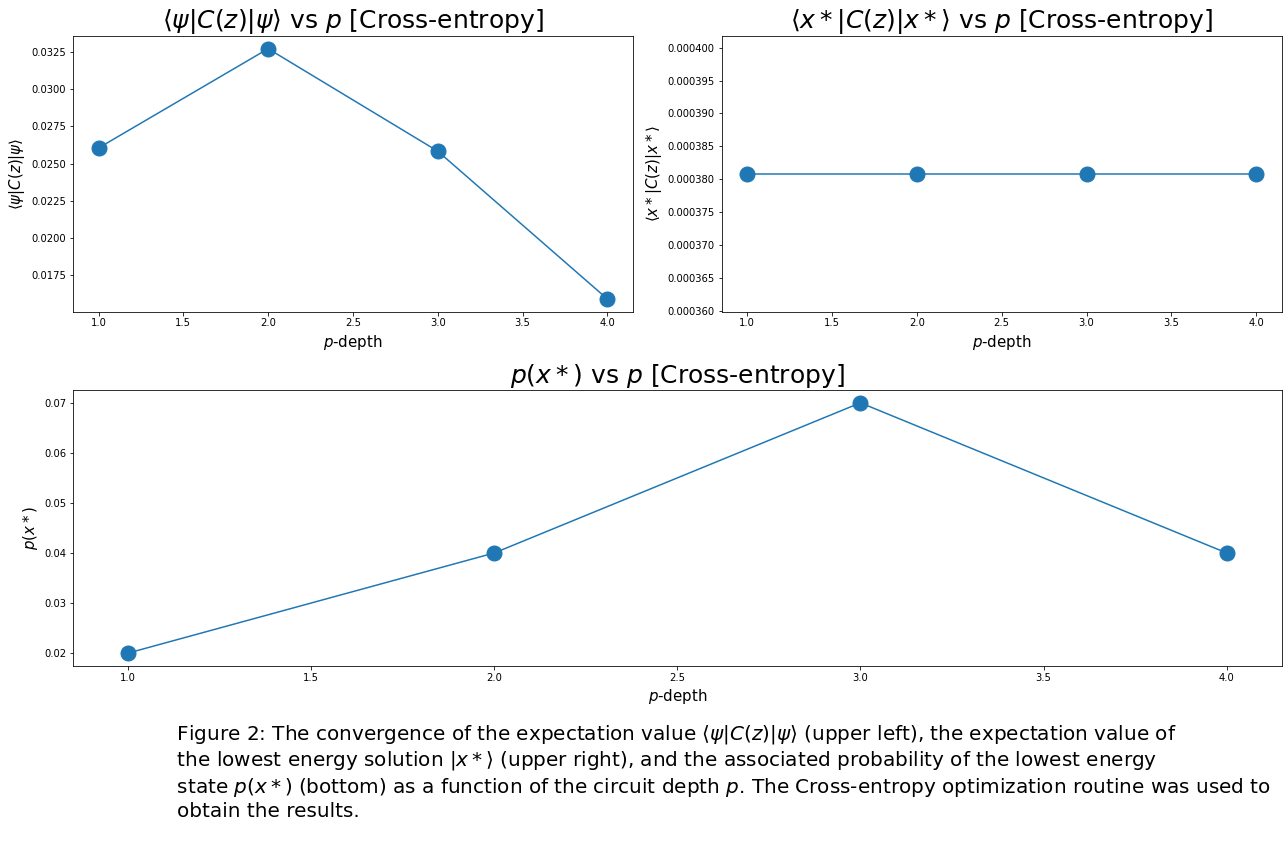

In [15]:
plot_parameters={}
plot_parameters['figure_number'] = 2
plot_parameters['optimizer_name'] = "Cross-entropy"
plot_parameters['optimizer_data'] = ce_optimization_array_QAOA
plot_parameters['p_depth'] = p_depth

scipy_plot = portfolio1.plot(plot_parameters)

plt.show()

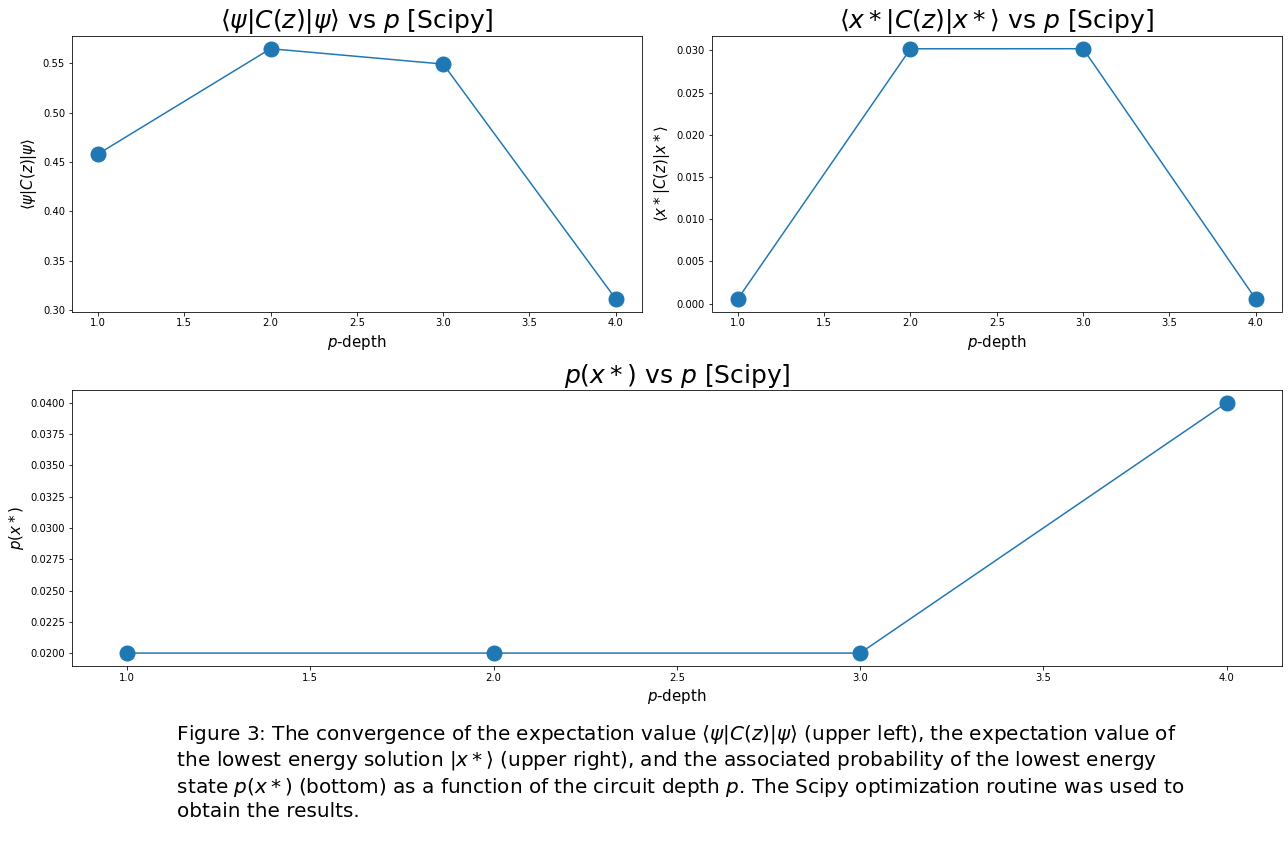

In [16]:
plot_parameters={}
plot_parameters['optimizer_name'] = "Scipy"
plot_parameters['figure_number'] = 3
plot_parameters['optimizer_data'] = scipy_optimization_array_QAOA
plot_parameters['p_depth'] = p_depth

scipy_plot = portfolio1.plot(plot_parameters)

plt.show()

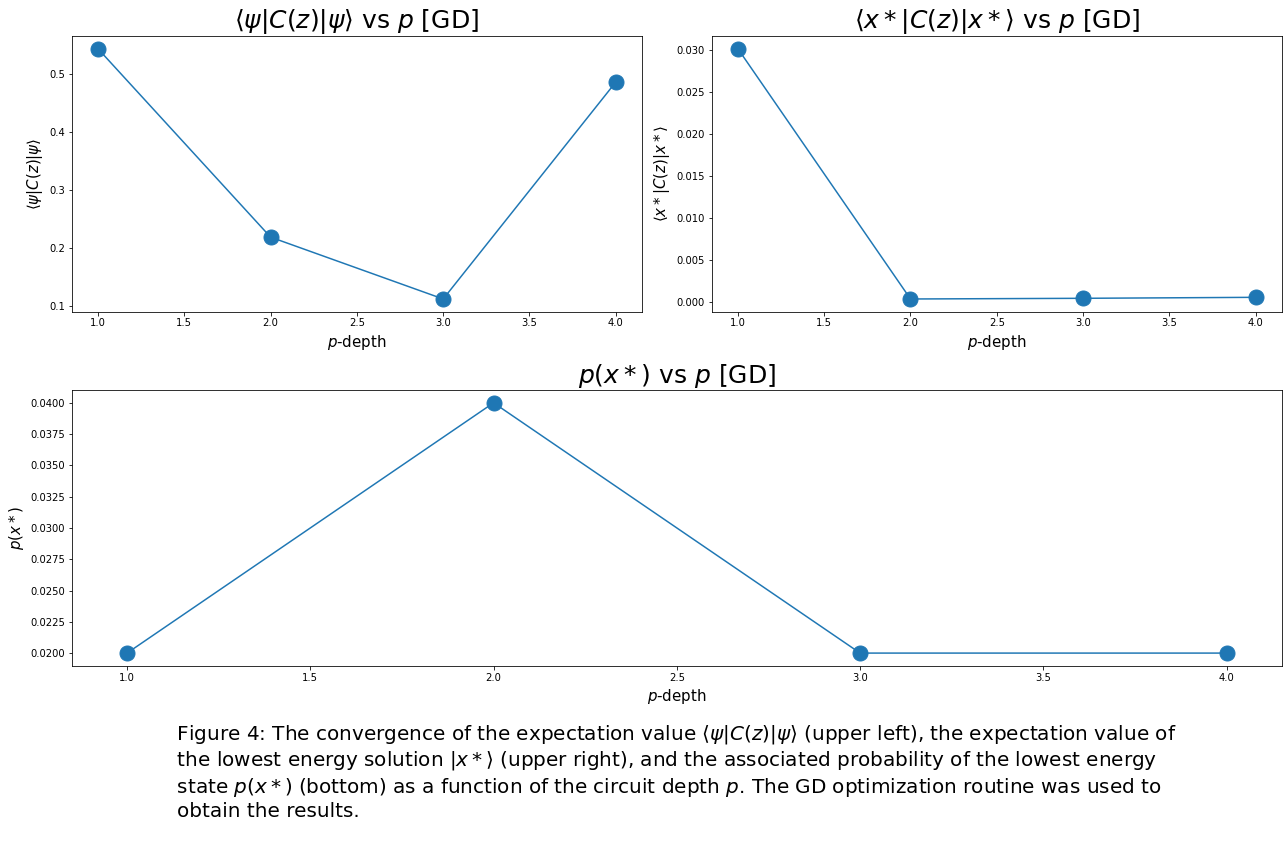

In [17]:
# Gradient descent [GD] applied to the QAOA circuit

plot_parameters={}
plot_parameters['figure_number'] = 4
plot_parameters['optimizer_name'] = "GD"
plot_parameters['optimizer_data'] = gd_optimization_array_QAOA
plot_parameters['p_depth'] = p_depth

scipy_plot = portfolio1.plot(plot_parameters)

plt.show()

<a id='QAOA_results_summary'></a>
## Summary of the final QAOA solutions with soft constraints at maximum depth

In [18]:
print('='*100)
print('QAOA-Summary')
print('Maximum depth: ', p_depth[-1])
print('-'*100)
print('Brute-Force optimal solution: ', best_bruteforce_result['minimum_cost_states'])
print()
print('Grid-Search: ', best_QAOA_result['minimum_cost_states'])
print('Probability of best solution: ',best_QAOA_result['minimum_cost_probabilities'])
print('minimum cost solution: ',best_QAOA_result['minimum_cost'])
print()
print('Gradient descent optimizer: ',gd_optimization_array_QAOA[-1]['best_solutions']['minimum_cost_states'])
print('Probability of best solution: ',gd_optimization_array_QAOA[-1]['best_solutions']['minimum_cost_probabilities'])
print('Approximation ratio: ',best_bruteforce_result['minimum_cost']/gd_optimization_array_QAOA[-1]['best_solutions']['minimum_cost'])
print()
print('Scipy-Optimizer: ',scipy_optimization_array_QAOA[-1]['best_solutions']['minimum_cost_states'])
print('Probability of best solution: ',scipy_optimization_array_QAOA[-1]['best_solutions']['minimum_cost_probabilities'])
print('Approximation ratio: ',best_bruteforce_result['minimum_cost']/scipy_optimization_array_QAOA[-1]['best_solutions']['minimum_cost'])
print()
print('Cross-Entropy Optimizer: ',ce_optimization_array_QAOA[-1]['best_solutions']['minimum_cost_states'])
print('Probability of best solution: ',ce_optimization_array_QAOA[-1]['best_solutions']['minimum_cost_probabilities'])
print('Approximation ratio: ',best_bruteforce_result['minimum_cost']/ce_optimization_array_QAOA[-1]['best_solutions']['minimum_cost'])
print('='*100)

QAOA-Summary
Maximum depth:  4
----------------------------------------------------------------------------------------------------
Brute-Force optimal solution:  [[1 0 1 0 1]]

Grid-Search:  [[1 0 1 0 1]]
Probability of best solution:  [0.04]
minimum cost solution:  0.00038080000000000004

Gradient descent optimizer:  [[0 1 1 1 0]]
Probability of best solution:  [0.02]
Approximation ratio:  0.6574926187475182

Scipy-Optimizer:  [[0 0 1 1 1]]
Probability of best solution:  [0.04]
Approximation ratio:  0.7052504861561256

Cross-Entropy Optimizer:  [[1 0 1 0 1]]
Probability of best solution:  [0.04]
Approximation ratio:  1.0


<a id='AOA_results_summary'></a>
# Construct the AOA Circuit 

Having constructed the QAOA circuit with soft constraints, we 

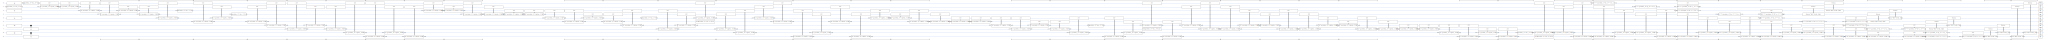

In [19]:
# Instantiate the portfolio 
portfolio1 = utils.Portfolio(N_portfolio=N_portfolio)

# Generate a QAOA circuit with p=1 depth
if(N_portfolio%2==0):
    D_const = N_portfolio/2
else:
    D_const = (N_portfolio+1)/2

AOA_circuit = portfolio1.AOA_circuit(p=1,D=D_const)

# plot the circuit
SVGCircuit(AOA_circuit)

<a id='AOA_grid_search'></a>
## Grid search of the angles for $p=1$

For visualization purposes we now conduct a grid-search of the AOA angle parameters and plot the expected value of the cost function.

In [20]:
# Determine the p=1 energy landscape for the QAOA 
if(load_from_file is True):
    AOA_results = portfolio1.load_data_from_json(data_folder+'/AOA_results.json')
else:
    AOA_results = portfolio1.grid_search(AOA_circuit,N_grid=N_grid,parameters=benchmark_parameters,n_trials=N_trials_grid)
    portfolio1.save_data_as_json(AOA_results,data_folder+'/AOA_results.json')


penalty_cost_grid_AOA = AOA_results['penalty_cost_grid']
total_cost_grid_AOA = AOA_results['total_cost_grid']
best_holdings_AOA = AOA_results['min_portfolio_holdings']

gamma_grid = AOA_results['gamma_grid']
beta_grid = AOA_results['beta_grid']

Minimum cost solution:  0.00042308000000000005
beta: 0.00* pi
gamma: 0.00* pi 


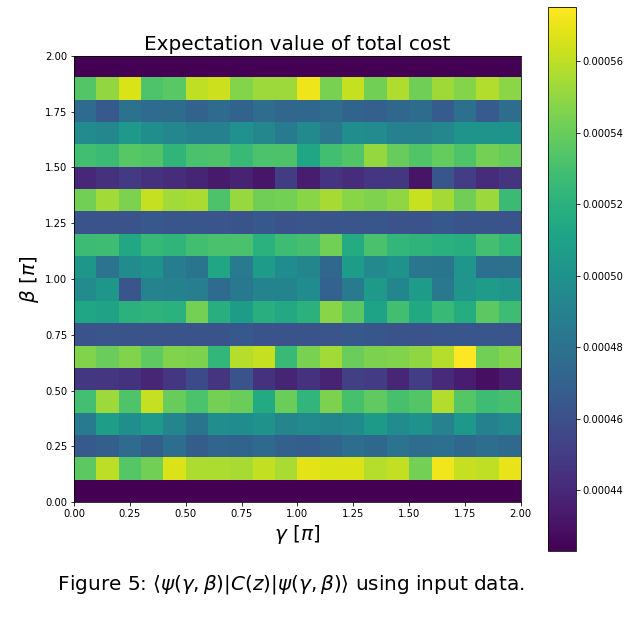

In [21]:
extent = [0.0,2.0, 0.0, 2.0]

print('='*100)
print('Minimum cost solution: ', AOA_results['minimum_cost'])
print('beta: {:.2f}* pi'.format(AOA_results['min_betas']/np.pi))
print('gamma: {:.2f}* pi '.format(AOA_results['min_gamma']/np.pi))
print('='*100)

plt.figure(figsize=(10,10))
plt.title('Expectation value of total cost',size=20)
plt.imshow(total_cost_grid_AOA[::-1],extent=extent)
plt.colorbar()
plt.xlabel(r'$\gamma \ [\pi]$',size=20)
plt.ylabel(r'$\beta \ [\pi]$',size=20)

text = r'''
        Figure {}: $\langle \psi(\gamma,\beta)|C(z)|\psi(\gamma,\beta) \rangle$ using input data.
        '''.format(5)
plt.text(-.3,-0.5, text, ha='left', size=20)
#plt.tight_layout()
plt.show()

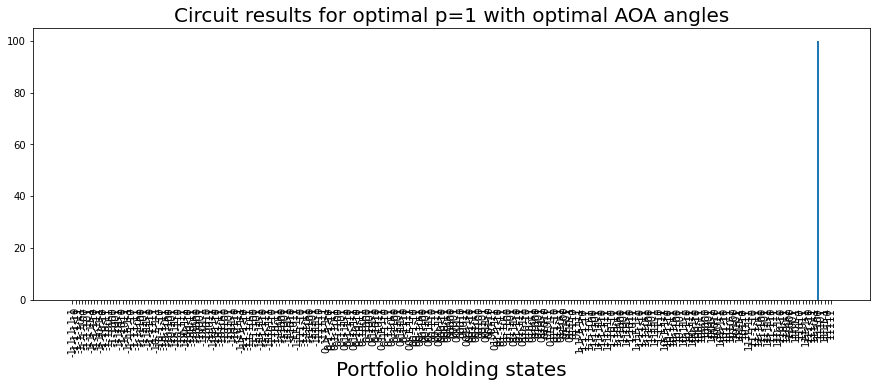

In [22]:
# Show the samples obtained from the experiments with the optimal angles

plt.figure(figsize=(15,5))
plt.title("Circuit results for optimal p=1 with optimal AOA angles",size=20)
plt.bar(np.arange(len(AOA_results['min_portfolio_holdings']['labels'])), AOA_results['min_portfolio_holdings']['counts'], tick_label=AOA_results['min_portfolio_holdings']['labels'])
plt.xticks(rotation=90)
plt.xlabel('Portfolio holding states',size=20)
plt.show()

In [23]:
# Get the best results from the gridsearch

best_AOA_result = portfolio1.determine_best_solution_from_trials(benchmark_parameters,best_holdings_AOA)

print('='*100)
print('QAOA results:')
print('Cost of optimal states: E={:.6f}'.format(best_AOA_result['minimum_cost']))
print('Minimum energy states: z={}'.format(best_AOA_result['minimum_cost_states']))
print('Probability of minimum cost states: p={}'.format(best_AOA_result['minimum_cost_probabilities']))
print('='*100)

QAOA results:
Cost of optimal states: E=0.000423
Minimum energy states: z=[[1 1 1 0 0]]
Probability of minimum cost states: p=[1.]


In [24]:
p_depth = np.array([1,2,3,4]).astype(int)

AOA_circuit_p_array = []


# Generate a QAOA circuit with p=1 depth
for p in p_depth:
    AOA_circuit_p_array.append(portfolio1.AOA_circuit(D=D_const,p=p))

## Optimize AOA cicuit using Scipy optimizer

In [25]:
# Optimize the AOA circuit using Scipy-optimizer
scipy_optimization_array_AOA= []

if(load_from_file is True):
    
    for p in range(len(p_depth)):
        scipy_optimization_results = portfolio1.load_data_from_json(data_folder+'/AOA_scipy_p'+str(p)+'.json')
        scipy_optimization_array_AOA.append(scipy_optimization_results)
else:

    for k in range(len(p_depth)):
        AOA_circuit_p = AOA_circuit_p_array[k]
        scipy_optimization_results = portfolio1.optimize_circuit(circuit=AOA_circuit_p,
                                                                 parameters=benchmark_parameters,
                                                                 n_trials=N_trials_scipy,
                                                                 p=p_depth[k])

        print('='*100)
        print('p-depth: ', p_depth[k])
        print('AOA scipy results:')
        print('Cost of optimal states: E={:.6f}'.format(scipy_optimization_results['best_solutions']['minimum_cost']))
        print('Minimum energy states: z={}'.format(scipy_optimization_results['best_solutions']['minimum_cost_states']))
        print('Probability of minimum cost states: p={}'.format(scipy_optimization_results['best_solutions']['minimum_cost_probabilities']))
        print('='*100)

        scipy_optimization_array_AOA.append(scipy_optimization_results)

# Save the results to a file
for p in range(len(p_depth)):
    portfolio1.save_data_as_json(scipy_optimization_array_AOA[p],data_folder+'/AOA_scipy_p'+str(p)+'.json')

Optimization terminated successfully.
         Current function value: 0.000505
         Iterations: 18
         Function evaluations: 45
optimal cost:  0.0005049896000000001
p-depth:  1
AOA scipy results:
Cost of optimal states: E=0.000423
Minimum energy states: z=[[1 1 1 0 0]]
Probability of minimum cost states: p=[0.34]
Optimization terminated successfully.
         Current function value: 0.000465
         Iterations: 25
         Function evaluations: 77
optimal cost:  0.0004648990000000001
p-depth:  2
AOA scipy results:
Cost of optimal states: E=0.000423
Minimum energy states: z=[[1 1 1 0 0]]
Probability of minimum cost states: p=[0.02]
Optimization terminated successfully.
         Current function value: 0.000492
         Iterations: 47
         Function evaluations: 128
optimal cost:  0.0004922192
p-depth:  3
AOA scipy results:
Cost of optimal states: E=0.000381
Minimum energy states: z=[[1 0 1 0 1]]
Probability of minimum cost states: p=[0.1]
Optimization terminated successful

## Optimize AOA cicuit using cross-entropy optimization

In [26]:
ce_optimization_array_AOA = []


if(load_from_file is True):
    
    for p in range(len(p_depth)):
        ce_results = portfolio1.load_data_from_json(data_folder+'/AOA_ce_p'+str(p)+'.json')
        ce_optimization_array_AOA.append(ce_results)
else:
    
    for k in range(len(p_depth)):
        AOA_circuit_p = AOA_circuit_p_array[k]

        ce_results =portfolio1.optimize_circuit_angles_cross_entropy(AOA_circuit_p,
                                                                     benchmark_parameters,
                                                                     p=p_depth[k],
                                                                     n_trials=N_trials_ce,
                                                                     iterations=N_ce_iterations,
                                                                     f_elite=f_elite,
                                                                     Nce_samples = N_ce_samples)
        print('='*100)
        print('p-depth: ', p_depth[k])
        print('AOA Cross entropy optimization results:')
        print('Cost of optimal states: E={:.6f}'.format(ce_results['best_solutions']['minimum_cost']))
        print('Minimum energy states: z={}'.format(ce_results['best_solutions']['minimum_cost_states']))
        print('Probability of minimum cost states: p={}'.format(ce_results['best_solutions']['minimum_cost_probabilities']))
        print('='*100)

        ce_optimization_array_AOA.append(ce_results)

# Save the results to a file
for p in range(len(p_depth)):
    portfolio1.save_data_as_json(scipy_optimization_array_AOA[p],data_folder+'/AOA_ce_p'+str(p)+'.json')

  0%|          | 0/50 [00:00<?, ?it/s]

k=0, mean_E=0.000435, std_E=0.000010, gammas[pi]=[0.30807129], betas[pi]=[1.90241911]


  0%|          | 0/50 [00:00<?, ?it/s]

k=1, mean_E=0.000433, std_E=0.000007, gammas[pi]=[0.40800815], betas[pi]=[1.90372585]


  0%|          | 0/50 [00:00<?, ?it/s]

k=2, mean_E=0.000426, std_E=0.000002, gammas[pi]=[0.53951416], betas[pi]=[1.89896418]


  0%|          | 0/50 [00:00<?, ?it/s]

k=3, mean_E=0.000443, std_E=0.000010, gammas[pi]=[0.59092679], betas[pi]=[1.80675561]


  0%|          | 0/50 [00:00<?, ?it/s]

k=4, mean_E=0.000433, std_E=0.000013, gammas[pi]=[0.60809332], betas[pi]=[1.79564184]


  0%|          | 0/50 [00:00<?, ?it/s]

k=5, mean_E=0.000448, std_E=0.000008, gammas[pi]=[0.62808124], betas[pi]=[1.79316354]


  0%|          | 0/50 [00:00<?, ?it/s]

k=6, mean_E=0.000442, std_E=0.000013, gammas[pi]=[0.70746039], betas[pi]=[1.68427397]


  0%|          | 0/50 [00:00<?, ?it/s]

k=7, mean_E=0.000428, std_E=0.000007, gammas[pi]=[0.62448817], betas[pi]=[1.79271543]


  0%|          | 0/50 [00:00<?, ?it/s]

k=8, mean_E=0.000429, std_E=0.000003, gammas[pi]=[0.54226125], betas[pi]=[1.90341106]


100%|██████████| 50/50 [00:31<00:00,  1.58it/s]


k=9, mean_E=0.000423, std_E=0.000000, gammas[pi]=[0.4597704], betas[pi]=[2.00483133]


  0%|          | 0/50 [00:00<?, ?it/s]

p-depth:  1
AOA Cross entropy optimization results:
Cost of optimal states: E=0.000423
Minimum energy states: z=[[1 1 1 0 0]]
Probability of minimum cost states: p=[1.]


  0%|          | 0/50 [00:00<?, ?it/s]

k=0, mean_E=0.000480, std_E=0.000009, gammas[pi]=[0.36938983 1.59179046], betas[pi]=[1.66178478 1.37020508]


  0%|          | 0/50 [00:00<?, ?it/s]

k=1, mean_E=0.000456, std_E=0.000019, gammas[pi]=[0.29969224 1.72651762], betas[pi]=[1.75292325 1.34861328]


  0%|          | 0/50 [00:00<?, ?it/s]

k=2, mean_E=0.000462, std_E=0.000012, gammas[pi]=[0.14434921 1.77014723], betas[pi]=[1.65833471 1.39960498]


  0%|          | 0/50 [00:00<?, ?it/s]

k=3, mean_E=0.000454, std_E=0.000016, gammas[pi]=[0.18606548 1.70109225], betas[pi]=[1.78052226 1.31222759]


  0%|          | 0/50 [00:00<?, ?it/s]

k=4, mean_E=0.000443, std_E=0.000011, gammas[pi]=[0.13403458 1.8223405 ], betas[pi]=[1.73024973 1.21733325]


  0%|          | 0/50 [00:00<?, ?it/s]

k=5, mean_E=0.000423, std_E=0.000001, gammas[pi]=[0.08114884 1.86339186], betas[pi]=[1.50668565 1.49165394]


  0%|          | 0/50 [00:00<?, ?it/s]

k=6, mean_E=0.000423, std_E=0.000000, gammas[pi]=[0.09547975 1.86600874], betas[pi]=[1.49569652 1.50678479]


  0%|          | 0/50 [00:00<?, ?it/s]

k=7, mean_E=0.000423, std_E=0.000000, gammas[pi]=[0.09943673 1.87208121], betas[pi]=[1.481555   1.52091073]


  0%|          | 0/50 [00:00<?, ?it/s]

k=8, mean_E=0.000423, std_E=0.000000, gammas[pi]=[0.09324735 1.86985013], betas[pi]=[1.48466691 1.51823053]


100%|██████████| 50/50 [00:55<00:00,  1.11s/it]


k=9, mean_E=0.000423, std_E=0.000000, gammas[pi]=[0.06231903 1.8609619 ], betas[pi]=[1.49542704 1.50907328]


  0%|          | 0/50 [00:00<?, ?it/s]

p-depth:  2
AOA Cross entropy optimization results:
Cost of optimal states: E=0.000423
Minimum energy states: z=[[1 1 1 0 0]]
Probability of minimum cost states: p=[1.]


  0%|          | 0/50 [00:00<?, ?it/s]

k=0, mean_E=0.000500, std_E=0.000007, gammas[pi]=[0.93582987 0.71076456 1.19161465], betas[pi]=[1.87414681 0.35659254 0.46955509]


  0%|          | 0/50 [00:00<?, ?it/s]

k=1, mean_E=0.000488, std_E=0.000032, gammas[pi]=[0.77040703 0.67637152 1.26902637], betas[pi]=[1.92440524 0.31491687 0.2920339 ]


  0%|          | 0/50 [00:00<?, ?it/s]

k=2, mean_E=0.000480, std_E=0.000006, gammas[pi]=[0.70518451 0.68108047 1.23920088], betas[pi]=[1.79977311 0.42973853 0.20254293]


  0%|          | 0/50 [00:00<?, ?it/s]

k=3, mean_E=0.000514, std_E=0.000008, gammas[pi]=[0.6352042  0.70140462 1.18551279], betas[pi]=[1.74114005 0.52260494 0.19498454]


  0%|          | 0/50 [00:00<?, ?it/s]

k=4, mean_E=0.000480, std_E=0.000027, gammas[pi]=[0.72008781 0.84267979 1.12218013], betas[pi]=[1.88802803 0.67104034 0.24208482]


  0%|          | 0/50 [00:00<?, ?it/s]

k=5, mean_E=0.000473, std_E=0.000026, gammas[pi]=[0.70283138 0.88981257 1.08490784], betas[pi]=[1.90949896 0.74254257 0.32096016]


  0%|          | 0/50 [00:00<?, ?it/s]

k=6, mean_E=0.000455, std_E=0.000015, gammas[pi]=[0.67187955 1.01004746 0.97280858], betas[pi]=[1.97011036 0.92896437 0.40110913]


  0%|          | 0/50 [00:00<?, ?it/s]

k=7, mean_E=0.000445, std_E=0.000006, gammas[pi]=[0.64976877 1.06289112 0.92205881], betas[pi]=[1.98946232 1.01623105 0.4510299 ]


  0%|          | 0/50 [00:00<?, ?it/s]

k=8, mean_E=0.000428, std_E=0.000002, gammas[pi]=[0.70509154 1.04972528 0.97230096], betas[pi]=[2.01926142 0.95869812 0.46947482]


100%|██████████| 50/50 [01:21<00:00,  1.63s/it]


k=9, mean_E=0.000427, std_E=0.000001, gammas[pi]=[0.67743228 1.04954834 0.95674563], betas[pi]=[2.0001051  0.97611515 0.47628208]


  0%|          | 0/50 [00:00<?, ?it/s]

p-depth:  3
AOA Cross entropy optimization results:
Cost of optimal states: E=0.000423
Minimum energy states: z=[[1 1 1 0 0]]
Probability of minimum cost states: p=[0.89]


  0%|          | 0/50 [00:00<?, ?it/s]

k=0, mean_E=0.000481, std_E=0.000020, gammas[pi]=[0.69050239 0.93079823 0.40458469 0.90162552], betas[pi]=[1.12317665 0.77487463 1.43100217 1.54643652]


  0%|          | 0/50 [00:00<?, ?it/s]

k=1, mean_E=0.000481, std_E=0.000025, gammas[pi]=[0.50541734 0.96675472 0.39006334 0.79350665], betas[pi]=[1.13395062 0.83820545 1.56271163 1.40902307]


  0%|          | 0/50 [00:00<?, ?it/s]

k=2, mean_E=0.000475, std_E=0.000031, gammas[pi]=[0.63593798 0.870007   0.40597794 0.78296871], betas[pi]=[1.09662238 0.82452719 1.49000808 1.38565074]


  0%|          | 0/50 [00:00<?, ?it/s]

k=3, mean_E=0.000512, std_E=0.000006, gammas[pi]=[0.7580819  0.77953373 0.26487046 0.92534974], betas[pi]=[1.20172225 0.67781642 1.5849769  1.2489528 ]


  0%|          | 0/50 [00:00<?, ?it/s]

k=4, mean_E=0.000491, std_E=0.000012, gammas[pi]=[0.16828841 0.883905   0.26350585 0.80865789], betas[pi]=[0.8979654  0.73878103 1.34787296 0.88605722]


  0%|          | 0/50 [00:00<?, ?it/s]

k=5, mean_E=0.000461, std_E=0.000007, gammas[pi]=[0.31596411 0.82726371 0.2352656  0.86608045], betas[pi]=[0.95664928 0.69191175 1.39020638 0.90647111]


  0%|          | 0/50 [00:00<?, ?it/s]

k=6, mean_E=0.000444, std_E=0.000004, gammas[pi]=[0.05082681 0.89430359 0.26834783 0.74986549], betas[pi]=[0.83687098 0.75777226 1.28538547 0.80642035]


  0%|          | 0/50 [00:00<?, ?it/s]

k=7, mean_E=0.000433, std_E=0.000001, gammas[pi]=[-0.07853117  0.92901642  0.28148244  0.70663299], betas[pi]=[0.77754218 0.78611418 1.23838647 0.7566805 ]


  0%|          | 0/50 [00:00<?, ?it/s]

k=8, mean_E=0.000430, std_E=0.000001, gammas[pi]=[-0.078937    0.92966886  0.27331636  0.72486027], betas[pi]=[0.77919084 0.77763953 1.24560602 0.74943709]


100%|██████████| 50/50 [01:53<00:00,  2.26s/it]


k=9, mean_E=0.000430, std_E=0.000001, gammas[pi]=[-0.08127307  0.93076866  0.26590856  0.7421707 ], betas[pi]=[0.77918239 0.77001031 1.25137419 0.74170016]
p-depth:  4
AOA Cross entropy optimization results:
Cost of optimal states: E=0.000423
Minimum energy states: z=[[1 1 1 0 0]]
Probability of minimum cost states: p=[0.93]


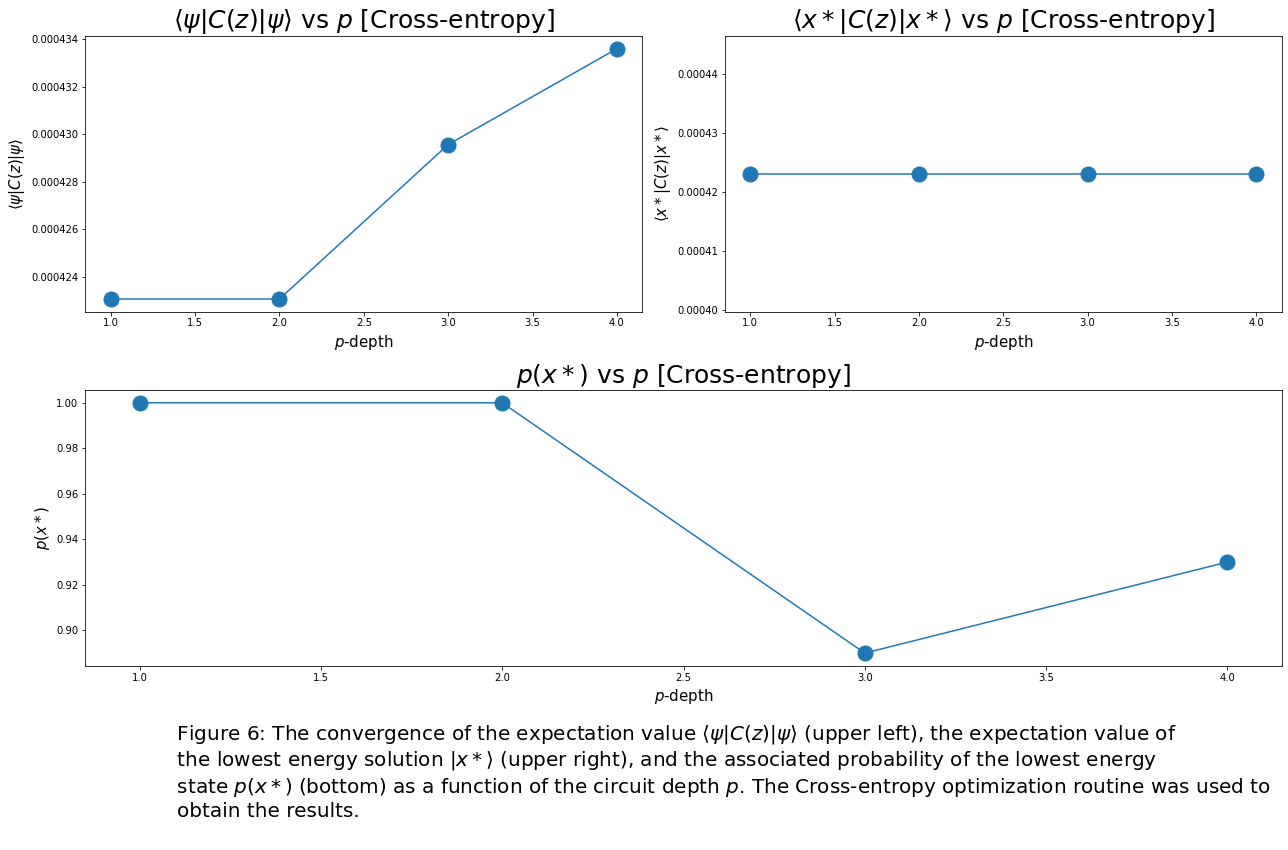

In [27]:
plot_parameters={}
plot_parameters['figure_number'] = 6
plot_parameters['optimizer_name'] = "Cross-entropy"
plot_parameters['optimizer_data'] = ce_optimization_array_AOA
plot_parameters['p_depth'] = p_depth

scipy_plot = portfolio1.plot(plot_parameters)

plt.show()

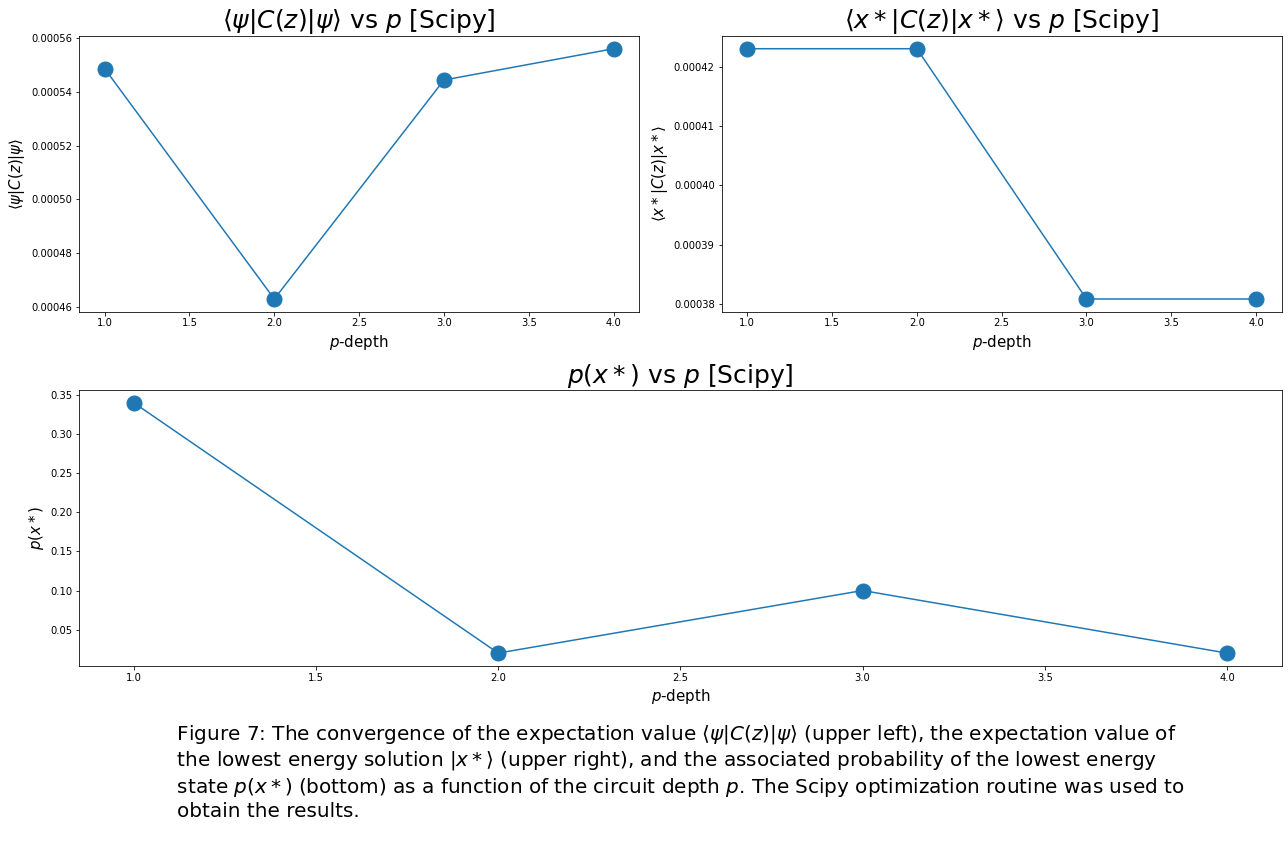

In [28]:
plot_parameters={}
plot_parameters['figure_number'] = 7
plot_parameters['optimizer_name'] = "Scipy"
plot_parameters['optimizer_data'] = scipy_optimization_array_AOA
plot_parameters['p_depth'] = p_depth

scipy_plot = portfolio1.plot(plot_parameters)

plt.show()

<a id='AOA_summary'></a>
## Summary of the final AOA solutions with hard constraints at maximum depth

In [29]:
print('='*100)
print('AOA-Summary')
print('Maximum depth: ', p_depth[-1])
print('-'*100)
print('Brute-Force optimal solution: ', best_bruteforce_result['minimum_cost_states'])
print('Brute-Force optimal solution: ', best_bruteforce_result['minimum_cost'])
print()
print('Grid-Search: ', best_AOA_result['minimum_cost_states'])
print('Probability of best solution: ',best_QAOA_result['minimum_cost_probabilities'])
print('Approximation ratio: ',best_bruteforce_result['minimum_cost']/best_QAOA_result['minimum_cost'])
print()
print('Scipy-Optimizer: ',scipy_optimization_array_AOA[-1]['best_solutions']['minimum_cost_states'])
print('Probability of best solution: ',scipy_optimization_array_AOA[-1]['best_solutions']['minimum_cost_probabilities'])
print('Approximation ratio: ',best_bruteforce_result['minimum_cost']/scipy_optimization_array_AOA[-1]['best_solutions']['minimum_cost'])
print()
print('Cross-Entropy Optimizer: ',ce_optimization_array_AOA[-1]['best_solutions']['minimum_cost_states'])
print('Probability of best solution: ',ce_optimization_array_AOA[-1]['best_solutions']['minimum_cost_probabilities'])
print('Approximation ratio: ',best_bruteforce_result['minimum_cost']/ce_optimization_array_AOA[-1]['best_solutions']['minimum_cost'])
print('='*100)

AOA-Summary
Maximum depth:  4
----------------------------------------------------------------------------------------------------
Brute-Force optimal solution:  [[1 0 1 0 1]]
Brute-Force optimal solution:  0.00038080000000000004

Grid-Search:  [[1 1 1 0 0]]
Probability of best solution:  [0.04]
Approximation ratio:  1.0

Scipy-Optimizer:  [[1 0 1 0 1]]
Probability of best solution:  [0.02]
Approximation ratio:  1.0

Cross-Entropy Optimizer:  [[1 1 1 0 0]]
Probability of best solution:  [0.93]
Approximation ratio:  0.900066181336863
